In [1]:
import tensorrt
import tensorflow as tf

2023-06-17 14:18:30.586473: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [53]:
import matplotlib.pyplot as plt
from pathlib import Path
import os

# Custom loss function

## Defining the custom Huber loss function

In [83]:
def custom_huber(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = 0.5 * tf.square(error)
    linear_loss = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

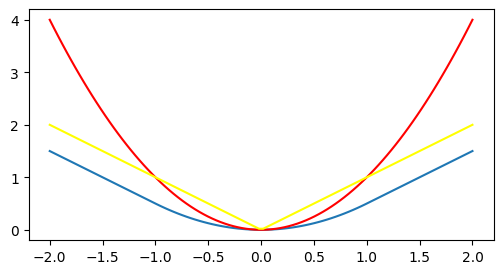

In [93]:
x = tf.cast(tf.linspace(-2, 2, 100), dtype=tf.float32)
z = tf.zeros(100)
fig, ax = plt.subplots(figsize=(6, 3))
ax: plt.Axes = ax
ax.plot(x, custom_huber(x, z))
ax.plot(x, tf.square(x), c='red')
ax.plot(x, tf.abs(x), c='yellow')
display()

## Building the model

In [44]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.boston_housing.load_data()

# Variables in order:
# CRIM     per capita crime rate by town
# ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
# INDUS    proportion of non-retail business acres per town
# CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
# NOX      nitric oxides concentration (parts per 10 million)
# RM       average number of rooms per dwelling
# AGE      proportion of owner-occupied units built prior to 1940
# DIS      weighted distances to five Boston employment centres
# RAD      index of accessibility to radial highways
# TAX      full-value property-tax rate per $10,000
# PTRATIO  pupil-teacher ratio by town
# B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
# LSTAT    % lower status of the population
# MEDV     Median value of owner-occupied homes in $1000's
features = 'CRIM ZN INDUS CHAS NOX RM AGE DIS RAD TAX PTRATIO B LSTAT MEDV'.split(' ')

In [45]:
x_train

array([[1.23247e+00, 0.00000e+00, 8.14000e+00, ..., 2.10000e+01,
        3.96900e+02, 1.87200e+01],
       [2.17700e-02, 8.25000e+01, 2.03000e+00, ..., 1.47000e+01,
        3.95380e+02, 3.11000e+00],
       [4.89822e+00, 0.00000e+00, 1.81000e+01, ..., 2.02000e+01,
        3.75520e+02, 3.26000e+00],
       ...,
       [3.46600e-02, 3.50000e+01, 6.06000e+00, ..., 1.69000e+01,
        3.62250e+02, 7.83000e+00],
       [2.14918e+00, 0.00000e+00, 1.95800e+01, ..., 1.47000e+01,
        2.61950e+02, 1.57900e+01],
       [1.43900e-02, 6.00000e+01, 2.93000e+00, ..., 1.56000e+01,
        3.76700e+02, 4.38000e+00]])

In [86]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer((13,)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(50, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(1)
])
model.compile(
    loss=custom_huber,
    optimizer=tf.keras.optimizers.Nadam(),
    metrics=[tf.metrics.mse]
)
rootdir = Path() / '01-huber'
logdir = rootdir / 'tensorboard'
print(Path(os.getcwd()) / logdir)
tensorboard_cb = tf.keras.callbacks.TensorBoard(logdir)
early_cb = tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=10)

/home/amitaharoni/workspace/homl3/ch12/01-huber/tensorboard


In [87]:
hist = model.fit(
    x_train,
    y_train,
    epochs=100,
    validation_split=0.2,
    callbacks=[tensorboard_cb, early_cb]
)

Epoch 1/100
11/11 [==============================] - 1s 19ms/step - loss: 10.7983 - mean_squared_error: 248.2993 - val_loss: 7.9607 - val_mean_squared_error: 158.2224
Epoch 2/100
11/11 [==============================] - 0s 9ms/step - loss: 7.3738 - mean_squared_error: 115.8356 - val_loss: 9.8264 - val_mean_squared_error: 202.7868
Epoch 3/100
11/11 [==============================] - 0s 9ms/step - loss: 6.5686 - mean_squared_error: 99.8717 - val_loss: 7.0356 - val_mean_squared_error: 130.2736
Epoch 4/100
11/11 [==============================] - 0s 10ms/step - loss: 5.4894 - mean_squared_error: 84.6555 - val_loss: 6.0616 - val_mean_squared_error: 94.4670
Epoch 5/100
11/11 [==============================] - 0s 9ms/step - loss: 5.1742 - mean_squared_error: 71.1678 - val_loss: 8.9742 - val_mean_squared_error: 121.5024
Epoch 6/100
11/11 [==============================] - 0s 10ms/step - loss: 5.5453 - mean_squared_error: 77.1977 - val_loss: 6.6253 - val_mean_squared_error: 91.5886
Epoch 7/100


In [88]:
model.evaluate(x_test, y_test)

4/4 [==============================] - 0s 3ms/step - loss: 3.8242 - mean_squared_error: 39.8018


[3.8242034912109375, 39.80180740356445]

## Saving and loading models with custom functions
Note that when saving and then loading the model, you'll have to provide a dictionary to resolve the loss function name `huber` to a python function.

In [89]:
savedir = rootdir / 'model'
model.save(savedir)

INFO:tensorflow:Assets written to: 01-huber/model/assets


INFO:tensorflow:Assets written to: 01-huber/model/assets


In [91]:
loaded_model = tf.keras.models.load_model(savedir)

ValueError: Unknown loss function: 'custom_huber'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [92]:
loaded_model = tf.keras.models.load_model(
    savedir,
    custom_objects=dict(custom_huber=custom_huber)
)
loaded_model.evaluate(x_test, y_test)

4/4 [==============================] - 0s 4ms/step - loss: 3.8242 - mean_squared_error: 39.8018


[3.8242034912109375, 39.80180740356445]

## Saving & Loading with hyperparameters
However, this will require some additional wrangling in case the custom loss function requires hyperparameters. One option is to create a factory function that receives the hyperparameters and returns a loss function that is a closure over those hyperparameters. This will require the loading concern to know the hyperparams used for the loss function, though.

An alternative option is to use a class, as below.

In [94]:
class CustomHuberLossFunction(tf.keras.losses.Loss):
    # threshold is the hyperparam
    # kwargs are by default `name` and `reduction` (AUTO, SUM_OVER_BATCH_SIZE, SUM, NONE)
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)

    # The huber loss function with the threshold hyperparam
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = 0.5 * tf.square(error)
        linear_loss = self.threshold * tf.abs(error) - 0.5 * self.threshold ** 2
        return tf.where(is_small_error, squared_loss, linear_loss)

    # This makes sure to store the hyperparams when the model is saved
    def get_config(self):
        base_config = super().get_config()
        return { **base_config, "threshold": self.threshold }

In [96]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer((13,)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(50, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(1)
])
model.compile(
    loss=CustomHuberLossFunction(2.),
    optimizer=tf.keras.optimizers.Nadam(),
    metrics=[tf.metrics.mse]
)
rootdir = Path() / '02-huber-class'
logdir = rootdir / 'tensorboard'
print(Path(os.getcwd()) / logdir)
tensorboard_cb = tf.keras.callbacks.TensorBoard(logdir)
early_cb = tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=10)

/home/amitaharoni/workspace/homl3/ch12/02-huber-class/tensorboard


In [97]:
hist = model.fit(
    x_train,
    y_train,
    epochs=100,
    validation_split=0.2,
    callbacks=[tensorboard_cb, early_cb]
)

Epoch 1/100
11/11 [==============================] - 1s 19ms/step - loss: 17.5584 - mean_squared_error: 190.2311 - val_loss: 15.9366 - val_mean_squared_error: 114.3810
Epoch 2/100
11/11 [==============================] - 0s 9ms/step - loss: 11.9857 - mean_squared_error: 91.5236 - val_loss: 18.6242 - val_mean_squared_error: 133.6235
Epoch 3/100
11/11 [==============================] - 0s 9ms/step - loss: 10.5427 - mean_squared_error: 79.5155 - val_loss: 9.9890 - val_mean_squared_error: 85.6912
Epoch 4/100
11/11 [==============================] - 0s 9ms/step - loss: 9.3354 - mean_squared_error: 70.2763 - val_loss: 9.8852 - val_mean_squared_error: 73.7387
Epoch 5/100
11/11 [==============================] - 0s 9ms/step - loss: 8.6164 - mean_squared_error: 63.8030 - val_loss: 14.5151 - val_mean_squared_error: 134.5355
Epoch 6/100
11/11 [==============================] - 0s 9ms/step - loss: 8.5650 - mean_squared_error: 64.1810 - val_loss: 17.5581 - val_mean_squared_error: 119.2367
Epoch 7/1

In [98]:
model.evaluate(x_test, y_test)

4/4 [==============================] - 0s 3ms/step - loss: 7.4481 - mean_squared_error: 43.5709


[7.448123931884766, 43.57090759277344]

In [99]:
savedir = rootdir / 'model'
model.save(savedir)

INFO:tensorflow:Assets written to: 02-huber-class/model/assets


INFO:tensorflow:Assets written to: 02-huber-class/model/assets


In [100]:
# We still need to refer it to the loss class
loaded_model = tf.keras.models.load_model(savedir)

ValueError: Unknown loss function: 'CustomHuberLossFunction'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [105]:
# But we do not need to provide the threshold hyperparameter!
loaded_model: tf.keras.Model = tf.keras.models.load_model(
    savedir,
    custom_objects=dict(CustomHuberLossFunction=CustomHuberLossFunction)
)
loaded_model.evaluate(x_test, y_test)

4/4 [==============================] - 0s 4ms/step - loss: 7.4481 - mean_squared_error: 43.5709


[7.448123931884766, 43.57090759277344]

# Activation, initialization, regularization, and constraints

In [106]:
def custom_softplus(z):
    return tf.math.log(1.0 + tf.exp(z))

def custom_glorot_init(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def custom_l1_regularizer(weights):
    return 0.01 * tf.reduce_sum(tf.abs(weights))

def custom_positive_constraint(weights: tf.Tensor):
    return tf.reduce_max(tf.zeros_like(weights), weights)

layer = tf.keras.layers.Dense(
    1,
    activation=custom_softplus,
    kernel_initializer=custom_glorot_init,
    kernel_regularizer=custom_l1_regularizer,        # Add the result to the loss
    kernel_constraint=custom_positive_constraint     # Replace the weights with the result
)

In [ ]:
tf.keras.regularizers.Regularizer